In [437]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
#import netCDF4 as nc
import pandas as pd
import os 

%matplotlib inline

# Using Skicit-learn to split data into training and testing sets
# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import sklearn.externals 
import joblib
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from itertools import cycle

# Data Preparation

In [234]:
# Load unbalanced raw dataset
file_unbal ='/auto/home/agiamala/rf_mhw/mat_unbalanced.csv'
mat_unbal = pd.read_csv(file_unbal, header = None)
mat_unbal.columns = ['day', 'month','year','doy', 'lon', 'lat', 'Qnet','slp', 'sat', 'wind_speed','sst', 'sstRoC', 'mhw_categories']

In [235]:
mat_unbal.head()

,day,month,year,doy,lon,lat,Qnet,slp,sat,wind_speed,sst,sstRoC,mhw_categories
0,1,1,1982,1,187.625,12.625,0.731018,-568.700000,11.166991,-0.726035,0.932887,-0.209477,0
1,1,1,1982,1,190.125,12.625,-0.864615,-319.066667,11.553665,0.309211,1.372802,-0.397347,0
2,1,1,1982,1,192.625,12.625,2.299962,-81.166667,11.784982,0.700121,1.124733,-0.328405,0
3,1,1,1982,1,195.125,12.625,25.466551,154.533333,11.476991,0.710585,1.013936,-0.153395,0
4,1,1,1982,1,197.625,12.625,56.970769,390.033333,9.841682,1.007320,0.784534,-0.025855,0


In [236]:
# Select unbalanced test dataset 2017-2018
valid_data = mat_unbal[(mat_unbal["year"] == 2017) | (mat_unbal["year"] == 2018) | (mat_unbal["year"] == 2019)]

In [237]:
valid_data.head()

,day,month,year,doy,lon,lat,Qnet,slp,sat,wind_speed,sst,sstRoC,mhw_categories
5113600,1,1,2017,1,187.625,12.625,116.213735,-501.200000,13.586974,8.482409,0.416275,-0.003609,0
5113601,1,1,2017,1,190.125,12.625,129.859558,10.933333,13.753677,9.436665,0.475611,0.011909,0
5113602,1,1,2017,1,192.625,12.625,130.422035,521.333333,14.000009,9.510640,0.472171,-0.013364,0
5113603,1,1,2017,1,195.125,12.625,103.499882,1011.533333,14.821992,8.186876,0.308234,0.038589,0
5113604,1,1,2017,1,197.625,12.625,59.395534,1457.033333,15.761665,6.305441,0.287014,-0.044616,0


In [238]:
valid_data.shape

(437600, 13)

In [239]:
# Merge severe and extreme MHW categories
valid_data["mhw_categories"] = valid_data["mhw_categories"].replace(4,3)

<ipython-input-239-01f4147d2171>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data["mhw_categories"] = valid_data["mhw_categories"].replace(4,3)


In [ ]:
# Make presence/absence only
#valid_data["mhw_categories"] = valid_data["mhw_categories"].replace(2,1)
#valid_data["mhw_categories"] = valid_data["mhw_categories"].replace(3,1)

In [250]:
# Checking if replacement of 4 with 3 categories worked
count_cat_valid = valid_data[(valid_data["mhw_categories"] == 0)]# | (allvars["mhw_categories"] == 2) | (allvars["mhw_categories"] == 3)]

In [251]:
np.shape(count_cat_valid)

(338110, 13)

In [197]:
labels_valid = np.array(valid_data['mhw_categories'])

# Remove the labels from the features
# axis 1 refers to the columns
valid_data= valid_data.drop('mhw_categories', axis = 1)
valid_data= valid_data.drop('year', axis = 1)
valid_data= valid_data.drop('sstRoC', axis = 1)
valid_data= valid_data.drop('day', axis = 1)
valid_data= valid_data.drop('month', axis = 1)

# Saving feature names for later use
valid_data_list = list(valid_data.columns)
valid_data_list

['doy', 'lon', 'lat', 'Qnet', 'slp', 'sat', 'wind_speed', 'sst']

In [198]:
print(valid_data.shape)
print(labels_valid.shape)

(437600, 8)
(437600,)


In [231]:
# Load balanced training dataset - 7 days lag
file_name = '/auto/home/agiamala/rf_mhw/movav_7_19new.csv'
colnames = ['day', 'month','year','doy', 'lon', 'lat', 'Qnet','slp', 'sat', 'wind_speed','sst', 'sstRoC', 'mhw_categories']
allvars = pd.read_csv(file_name, names = colnames, header = None)

In [232]:
allvars.tail()

,day,month,year,doy,lon,lat,Qnet,slp,sat,wind_speed,sst,sstRoC,mhw_categories
1144436,23,12,2019,357,215.125,55.125,213.169765,-48.566667,0.266614,2.346308,2.008487,-0.027102,1
1144437,23,12,2019,357,217.625,55.125,181.646030,-16.395238,-0.106776,1.503766,1.910056,-0.005740,1
1144438,23,12,2019,357,220.125,55.125,150.576762,-5.485714,-0.309338,1.012491,1.648987,-0.016497,1
1144439,23,12,2019,357,222.625,55.125,133.883315,-6.280952,-0.357060,0.499175,1.161563,-0.018092,1
1144440,23,12,2019,357,220.125,57.625,143.794209,-27.528571,-0.266393,1.997759,0.893055,0.002820,1


In [233]:
# Merge severe and extreme MHW categories
allvars["mhw_categories"] = allvars["mhw_categories"].replace(4,3)

In [ ]:
# Make presence/absence only
#allvars["mhw_categories"] = allvars["mhw_categories"].replace(2,1)
#allvars["mhw_categories"] = allvars["mhw_categories"].replace(3,1)

In [202]:
allvars = allvars.drop(allvars.index[(allvars["year"] == 2017) | (allvars["year"] == 2018) | (allvars["year"] == 2019)], axis=0) 

In [203]:
allvars.shape

(869927, 13)

In [230]:
# Checking if replacement of 4 with 3 categories worked
count_cat = allvars[(allvars["mhw_categories"] == 1)]# | (allvars["mhw_categories"] == 2) | (allvars["mhw_categories"] == 3)]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [106]:
count_cat.shape

(531262, 13)

In [204]:
# Labels are the values we want to predict
labels = np.array(allvars['mhw_categories'])

# Remove the labels from the features
allvars = allvars.drop('mhw_categories', axis = 1)
allvars = allvars.drop('year', axis = 1)
allvars = allvars.drop('sstRoC', axis = 1)
allvars = allvars.drop('day', axis = 1)
allvars = allvars.drop('month', axis = 1)

# Saving feature names for later use
allvars_list = list(allvars.columns)
allvars_list

['doy', 'lon', 'lat', 'Qnet', 'slp', 'sat', 'wind_speed', 'sst']

In [205]:
# Convert to numpy array
allvars = np.array(allvars)

In [206]:
allvars.shape

(869927, 8)

In [207]:
X_train = allvars
y_train = labels

X_test = valid_data
y_test = labels_valid

In [ ]:
# Split the data into training and testing sets
# the random_state parameter is used for initializing the internal random number generator, 
# which will decide the splitting of data into train and test indices.
#train_allvars, test_allvars, train_labels, test_labels = train_test_split(allvars, labels, test_size = 0.0, random_state = 42)

In [208]:
print('Training allvars Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing allvars Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training allvars Shape: (869927, 8)
Training Labels Shape: (869927,)
Testing allvars Shape: (437600, 8)
Testing Labels Shape: (437600,)


# Randomized Cross Validation

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 9)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 1)
# Fit the random search model
rf_random.fit(train_allvars, train_labels)

In [ ]:
rf_random.best_estimator_

In [ ]:
rf_random.cv_results_

In [ ]:
# Get CV results

rf_random.best_params_
df_cv_results = pd.DataFrame(rf_random.cv_results_)
df_cv_results.head()

In [ ]:
df_cv_results.to_csv('df_cv_results.csv')

In [ ]:
# Define evaluation means function
def evaluate(model, valid_data, labels_valid):
    predictions = model.predict(valid_data)
    predictions1 = predictions + 1 
    test_labels1 = labels_valid + 1
    errors = abs(predictions1 - test_labels1)
    mape = 100 * np.mean(errors / test_labels1)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
# Evaluate best model against base model
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(train_allvars, train_labels)
base_accuracy = evaluate(base_model, valid_data, labels_valid)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, valid_data, labels_valid)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [ ]:
# Save -- too large file 
joblib.dump(rf_random, 'rf_random_last.pkl')

# Random Forest
# Run RF with best model identified by CV 

In [22]:
# Assign weights - default for 0s and 1s and double weighting for 2s and 3s
# weights = {0:1.0, 1:1.0, 2:2.0, 3:2.0}

# Instantiate model with N decision trees
rfc = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4, min_samples_split=5, n_estimators=700, random_state = 42, bootstrap=True, oob_score=True) # class_weight=weights,
#rf_200 = RandomForestClassifier(n_estimators = 200, bootstrap=False , min_samples_split=2, min_samples_leaf=1, max_features="sqrt", random_state = 42, max_depth=80, oob_score=False)

# Train the model on training data
rfc.fit(X_train, y_train);

In [23]:
print('Score against train set: ', rfc.score(X_train, y_train))
print('OOB Score: ', rfc.oob_score_) # only if bootstrap=True
print('Score against test set: ', rfc.score(X_test, y_test))

Score against train set:  0.7278875124004658
OOB Score:  0.7233744900434175
Score against test set:  0.7160260511882999


In [148]:
# Make predictions for the test set
yc_pred_test = rfc.predict(X_test)

# Add 1 to be able to do the division for MAPE 
yc_pred_test1 = yc_pred_test + 1
test_labels1 = labels_valid + 1

In [347]:
np.savetxt("ycv_pred_700trees.csv", yc_pred_test, delimiter=" ")

In [25]:
# Calculate the absolute errors
errorsc = abs(yc_pred_test1 - test_labels1)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errorsc), 2))

Mean Absolute Error: 0.31


In [26]:
# Calculate mean absolute percentage error (MAPE)
mapec = 100 * (errorsc / test_labels1)
# Calculate and display accuracy
accuracyc = 100 - np.mean(mapec)
print('Accuracy:', round(accuracyc, 2), '%.')

Accuracy: 78.77 %.


In [209]:
# AUC
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(yc_pred_test1, y_test, pos_label=2)
metrics.auc(false_positive_rate, true_positive_rate)

0.710632515028961

In [210]:
print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 700,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [29]:
np.savetxt("labels_valid.csv", y_test, delimiter=" ")

## Confusion Matrix

In [224]:
# View confusion matrix for test data and predictions
confusion_matrix(y_test, yc_pred_test)

array([[273519,  62320,   2229,     42],
       [ 17516,  35884,   3641,     35],
       [  5521,  28416,   3930,     62],
       [   682,   3014,    789,      0]])

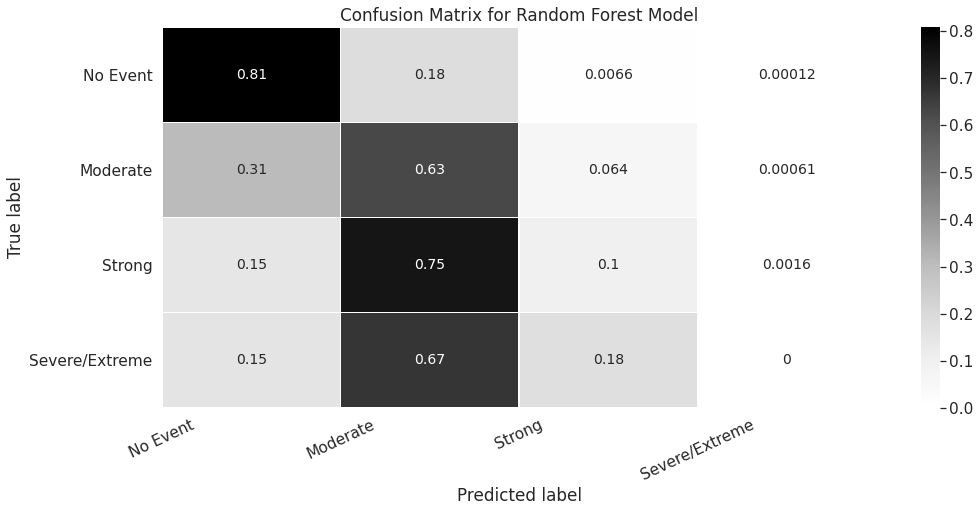

In [221]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, yc_pred_test, normalize = 'true')
#matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':14},
            cmap=plt.cm.Greys, linewidths=0.2)

# Add labels to the plot
class_names = ['No Event','Moderate', 'Strong', 'Severe/Extreme'] # 'Severe','Extreme']
#class_names = ['Absence', 'Presence']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

Total number of MHW pixels:

No event = 338110,
Moderate = 57076,
Strong = 37929,
Severe/Extreme = 4485

In [52]:
confusion_matrix(y_test, yc_pred_test)

array([[273519,  62320,   2229,     42],
       [ 17516,  35884,   3641,     35],
       [  5521,  28416,   3930,     62],
       [   682,   3014,    789,      0]])

In [276]:
# recall = 
273519/(273519+62320)

0.8144348929099956

In [283]:
# precision = 
273519/(273519+17516)

0.9398147989073479

In [212]:
tn, fp, fn, tp = confusion_matrix(y_test, yc_pred_test)

In [286]:
tp

array([ 682, 3014,  789,    0])

In [214]:
print(classification_report(y_test, yc_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86    338110
           1       0.28      0.63      0.38     57076
           2       0.37      0.10      0.16     37929
           3       0.00      0.00      0.00      4485

    accuracy                           0.72    437600
   macro avg       0.39      0.39      0.35    437600
weighted avg       0.78      0.72      0.73    437600



## Feature Importance

In [215]:
importances = rfc.feature_importances_
print(importances)

[0.04257151 0.02914539 0.04788145 0.03109526 0.02373557 0.03393956
 0.00958693 0.78204433]


Variable: sst                  Importance: 0.78
Variable: lat                  Importance: 0.05
Variable: doy                  Importance: 0.04
Variable: lon                  Importance: 0.03
Variable: Qnet                 Importance: 0.03
Variable: sat                  Importance: 0.03
Variable: slp                  Importance: 0.02
Variable: wind_speed           Importance: 0.01


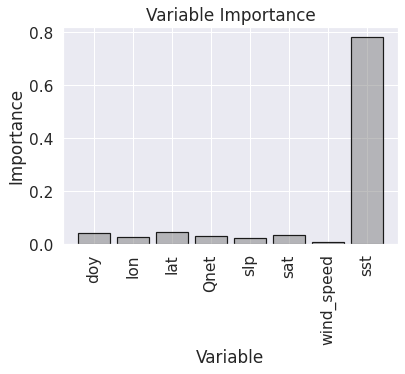

In [216]:
columns = ['doy', 'lon', 'lat', 'Qnet','slp', 'sat', 'wind_speed','sst']
feature_list = list(columns)

# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = (0.5, 0.5, 0.5, 0.5), edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation = 'vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importance');

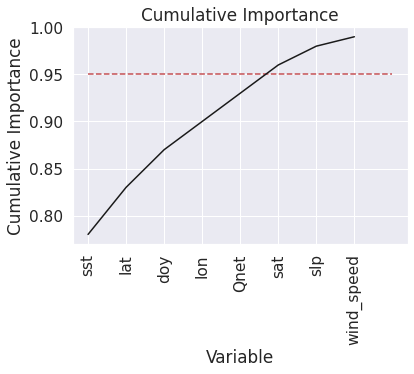

In [440]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'k-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importance');

plt.savefig('cum_imp_700lag.jpg', dpi=600)

plt.show()

## Precision - Recall Curve

In [217]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = Y.shape[1]

print(n_classes)

4


In [160]:
Y.shape

(437600, 4)

In [154]:
# Predict probabilities for each class
lr_probs = rfc.predict_proba(X_test)

In [ ]:
np.savetxt("lr_probs.csv", lr_probs, delimiter=" , ")

In [319]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                        lr_probs[:, i])
    average_precision[i] = average_precision_score(Y[:, i], lr_probs[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(),
    lr_probs.ravel())
average_precision["micro"] = average_precision_score(Y, lr_probs,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.85


In [326]:
precision

{0: array([0.77266921, 0.77266869, 0.77267045, ..., 1.        , 1.        ,
        1.        ]),
 1: array([0.13056478, 0.13056279, 0.13056309, ..., 0.5       , 1.        ,
        1.        ]),
 2: array([0.09207208, 0.09206987, 0.0920701 , ..., 0.5       , 1.        ,
        1.        ]),
 3: array([0.0106481 , 0.01064575, 0.01064577, ..., 0.        , 0.        ,
        1.        ]),
 'micro': array([0.25236418, 0.25236375, 0.2523639 , ..., 1.        , 1.        ,
        1.        ])}

In [320]:
data = list(precision. items())

In [322]:
an_array = np. array(data)

<ipython-input-322-b8a2e33c8f1b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  an_array = np. array(data)


In [327]:
an_array

array([[0,
        array([0.77266921, 0.77266869, 0.77267045, ..., 1.        , 1.        ,
       1.        ])],
       [1,
        array([0.13056478, 0.13056279, 0.13056309, ..., 0.5       , 1.        ,
       1.        ])],
       [2,
        array([0.09207208, 0.09206987, 0.0920701 , ..., 0.5       , 1.        ,
       1.        ])],
       [3,
        array([0.0106481 , 0.01064575, 0.01064577, ..., 0.        , 0.        ,
       1.        ])],
       ['micro',
        array([0.25236418, 0.25236375, 0.2523639 , ..., 1.        , 1.        ,
       1.        ])]], dtype=object)

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.85')

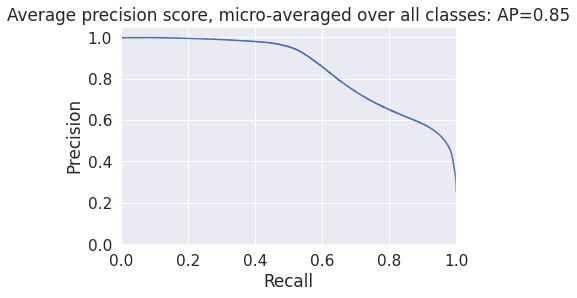

In [167]:
# Plot average precision-recall curve
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

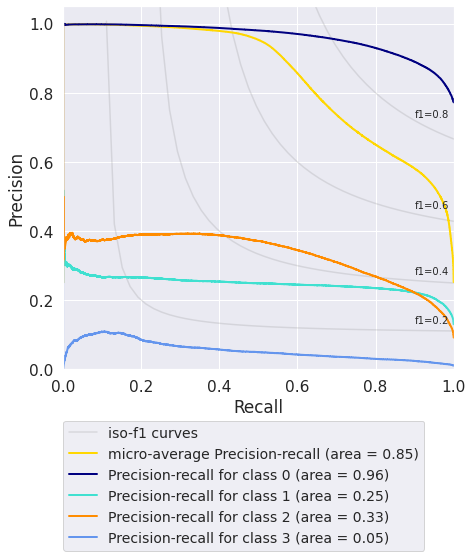

In [399]:
# Setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize = (7, 8))
#ax1 = plt.subplot2grid((7, 8), (0, 0), colspan=20, rowspan=15)
f_scores = np.linspace(0.2, 0.8, num = 4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(lines, labels, loc=(0, -0.5), prop=dict(size=14))
plt.show()

Adjusting Classification Threshold

In [330]:
from sklearn.metrics import det_curve

for i in range(n_classes):
    _ , _ ,thresholds = det_curve(Y[:, i], lr_probs[:, i])
    
#sklearn.metrics.det_curve(y_test, y_score, pos_label=None, sample_weight=None)[source]

In [331]:
thresholds

array([0.00088409, 0.00088409, 0.00088409, ..., 0.41862245, 0.41913626,
       0.42261497])

## ROC curve

In [70]:
np.shape(yc_pred_test)

(437600,)

In [173]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], lr_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), lr_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [253]:
fpr

{0: array([0.        , 0.        , 0.        , ..., 0.99986933, 0.99986933,
        1.        ]),
 1: array([0.00000000e+00, 0.00000000e+00, 2.62795514e-06, ...,
        9.98809536e-01, 9.98809536e-01, 1.00000000e+00]),
 2: array([0.00000000e+00, 0.00000000e+00, 7.50617383e-06, ...,
        9.35819712e-01, 9.35819712e-01, 1.00000000e+00]),
 3: array([0.00000000e+00, 2.30885562e-06, 9.18924535e-04, ...,
        9.62139386e-01, 9.62139386e-01, 1.00000000e+00]),
 'micro': array([0.        , 0.        , 0.        , ..., 0.98750914, 0.98750914,
        1.        ]),
 'macro': array([0.00000000e+00, 2.30885562e-06, 2.62795514e-06, ...,
        9.99819077e-01, 9.99869334e-01, 1.00000000e+00])}

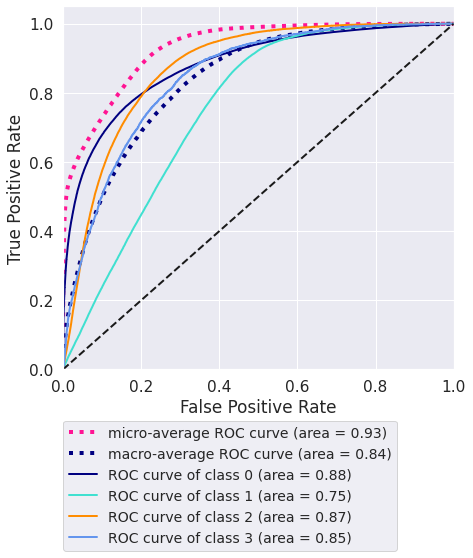

In [401]:
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure()

plt.figure(figsize = (7, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
#colors = cycle(['navy', 'turquoise', 'cornflowerblue', 'teal'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
#fig = plt.gcf()
plt.subplots_adjust(bottom=0.25)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic for MHW multi-class')
plt.legend(loc=(0, -0.5), prop=dict(size=14))
#plt.legend(loc="lower right")
plt.show()

### ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. 

### The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

### ROC curves are typically used in binary classification to study the output of a classifier. In order to extend ROC curve and ROC area to multi-label classification, it is necessary to binarize the output. One ROC curve can be drawn per label, but one can also draw a ROC curve by considering each element of the label indicator matrix as a binary prediction (micro-averaging).

### Another evaluation measure for multi-label classification is macro-averaging, which gives equal weight to the classification of each label.

In [389]:

# Setup PR curve details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

#plt.figure(figsize = (7, 8)), colspan=10, rowspan=15

f_scores = np.linspace(0.2, 0.8, num = 4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

ax1 = plt.subplot2grid((0, 1, (7, 8))
#fig = plt.gcf()
#ax1.subplots_adjust(bottom=0.25)
ax1.xlim([0.0, 1.0])
ax1.ylim([0.0, 1.05])
ax1.xlabel('Recall')
ax1.ylabel('Precision')
ax1.legend(lines, labels, loc=(0, -1), prop=dict(size=14))

#Setup ROC curve details
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure(), colspan=10, rowspan=15
ax2 = plt.subplot2grid(0, 0, (7, 8))
#plt.figure(figsize = (7, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
#colors = cycle(['navy', 'turquoise', 'cornflowerblue', 'teal'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
#fig = plt.gcf()
#plt.subplots_adjust(bottom=0.25)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic for MHW multi-class')
plt.legend(loc=(0, -1), prop=dict(size=14))
#plt.legend(loc="lower right")
plt.show()

SyntaxError: invalid syntax (<ipython-input-389-128a3181de37>, line 31)